x_train.shape: (50000, 32, 32, 3), y_train.shape: (50000, 1)
x_test.shape: (10000, 32, 32, 3), y_test.shape: (10000, 1)


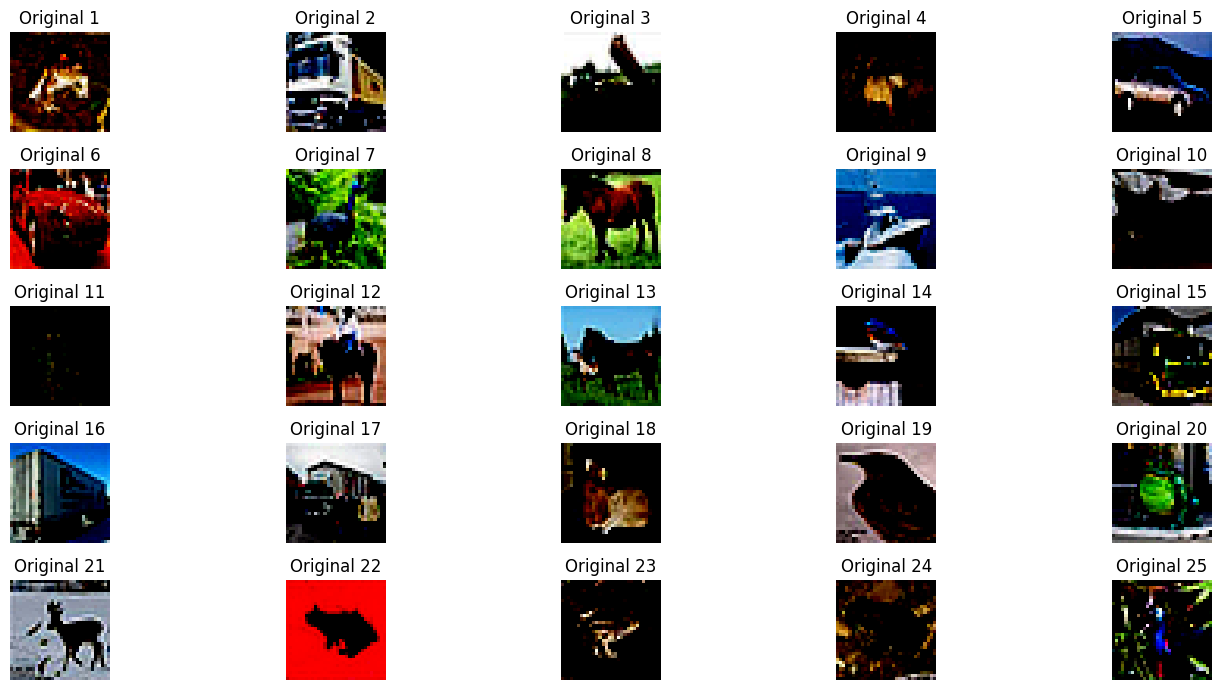

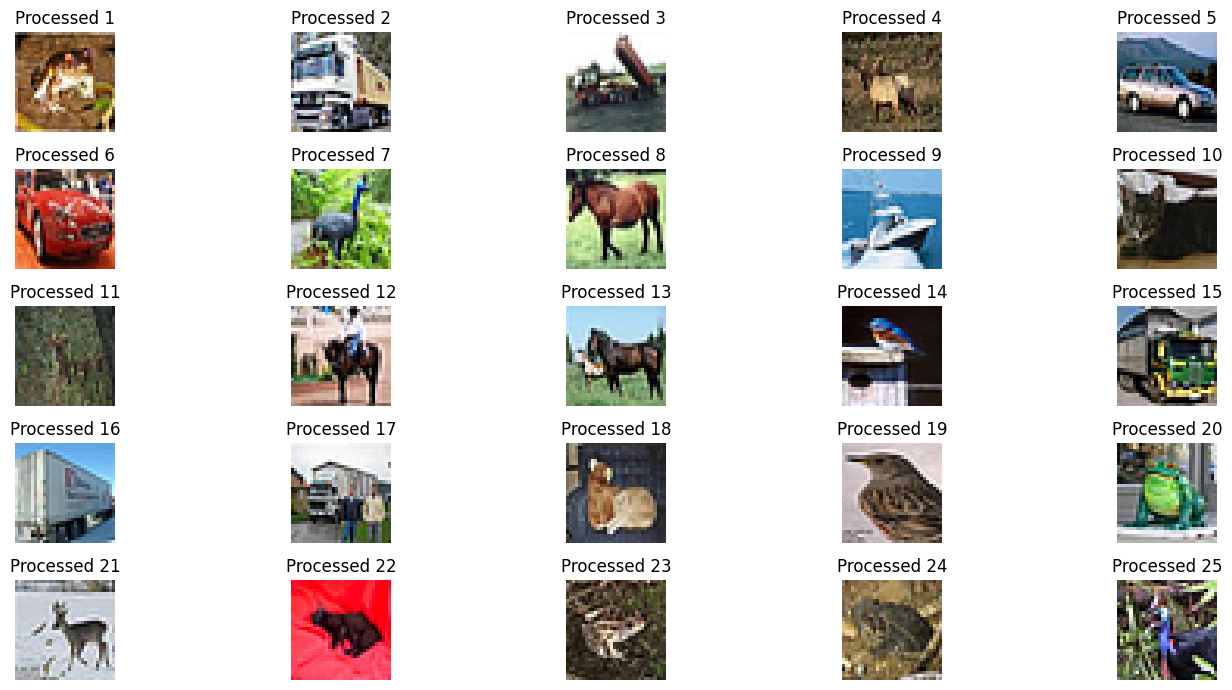

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4157 - loss: 1.7012 - val_accuracy: 0.6635 - val_loss: 0.9512
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6581 - loss: 0.9742 - val_accuracy: 0.7240 - val_loss: 0.7788
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7234 - loss: 0.7916 - val_accuracy: 0.7554 - val_loss: 0.7060
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7555 - loss: 0.7008 - val_accuracy: 0.7811 - val_loss: 0.6277
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7818 - loss: 0.6330 - val_accuracy: 0.8050 - val_loss: 0.5750
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8010 - loss: 0.5699 - val_accuracy: 0.8060 - val_loss: 0.5677
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8207 - loss: 0.5192 - val_accuracy: 0.8249 - val_loss: 0.5073
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8368 - loss: 0.47

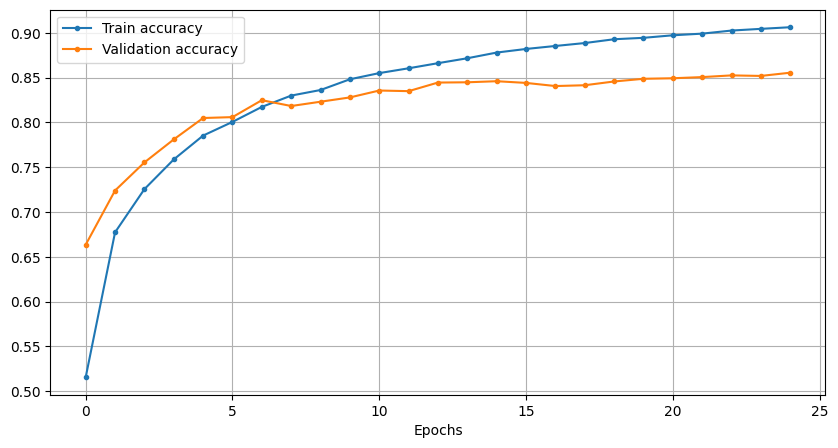

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
import tensorflow as tf

#COM BLUR PRÉ SHARPENING

# Carregar o dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Exibir as dimensões dos dados
print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")

# Parâmetros da Unsharp Mask
upscale_factor = 2
kernel_size = (3, 3)
sigma = 1
amount = 6

# Pré-processar x_train
processed_train = np.zeros_like(x_train)
for i in range(x_train.shape[0]):
    img_bgr = cv2.cvtColor(x_train[i], cv2.COLOR_RGB2BGR)
    upscale_dim = (x_train.shape[2] * upscale_factor, x_train.shape[1] * upscale_factor)
    img_upscaled = cv2.resize(img_bgr, upscale_dim, interpolation=cv2.INTER_CUBIC)
    blurred = cv2.GaussianBlur(img_upscaled, kernel_size, sigma)
    sharpened_upscaled = cv2.addWeighted(img_upscaled, 1 + amount, blurred, -amount, 0)
    sharpened_bgr = cv2.resize(sharpened_upscaled, (x_train.shape[2], x_train.shape[1]), interpolation=cv2.INTER_AREA)
    processed_train[i] = cv2.cvtColor(sharpened_bgr, cv2.COLOR_BGR2RGB)

# Pré-processar x_test
processed_test = np.zeros_like(x_test)
for i in range(x_test.shape[0]):
    img_bgr = cv2.cvtColor(x_test[i], cv2.COLOR_RGB2BGR)
    upscale_dim = (x_test.shape[2] * upscale_factor, x_test.shape[1] * upscale_factor)
    img_upscaled = cv2.resize(img_bgr, upscale_dim, interpolation=cv2.INTER_CUBIC)
    blurred = cv2.GaussianBlur(img_upscaled, kernel_size, sigma)
    sharpened_upscaled = cv2.addWeighted(img_upscaled, 1 + amount, blurred, -amount, 0)
    sharpened_bgr = cv2.resize(sharpened_upscaled, (x_test.shape[2], x_test.shape[1]), interpolation=cv2.INTER_AREA)
    processed_test[i] = cv2.cvtColor(sharpened_bgr, cv2.COLOR_BGR2RGB)

# Normalizar as imagens para o intervalo [-1, 1]
x_train, x_test = (processed_train / 255.0 - 0.5) * 2, (processed_test / 255.0 - 0.5) * 2

# Plotar as primeiras 25 imagens da base antes e depois do upscaling
fig, axes = plt.subplots(5, 5, figsize=(15, 7))
axes = axes.flatten()

# Plotar as primeiras 25 imagens originais e processadas
for i in range(25):
    # Imagem original
    axes[i].imshow(x_train[i])
    axes[i].set_title(f'Original {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Plotar as imagens processadas (após o upscaling e sharpen)
fig, axes = plt.subplots(5, 5, figsize=(15, 7))
axes = axes.flatten()

for i in range(25):
    # Imagem processada
    axes[i].imshow(processed_train[i])
    axes[i].set_title(f'Processed {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Criar o modelo
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Primeiro bloco convolucional
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Segundo bloco convolucional
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Terceiro bloco convolucional
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Camadas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')  # Saída para 10 classes
])

# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

# Avaliar o modelo
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plotar histórico de treinamento
plt.figure(figsize=(10, 5))

# Acurácia
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], '.-', label='Train accuracy')
plt.plot(history.history['val_accuracy'], '.-', label='Validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

plt.show()

# Salvar o modelo treinado
model.save('/content/drive/MyDrive/Colab Notebooks/v44.h5')


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
x_train.shape: (50000, 32, 32, 3), y_train.shape: (50000, 1)
x_test.shape: (10000, 32, 32, 3), y_test.shape: (10000, 1)


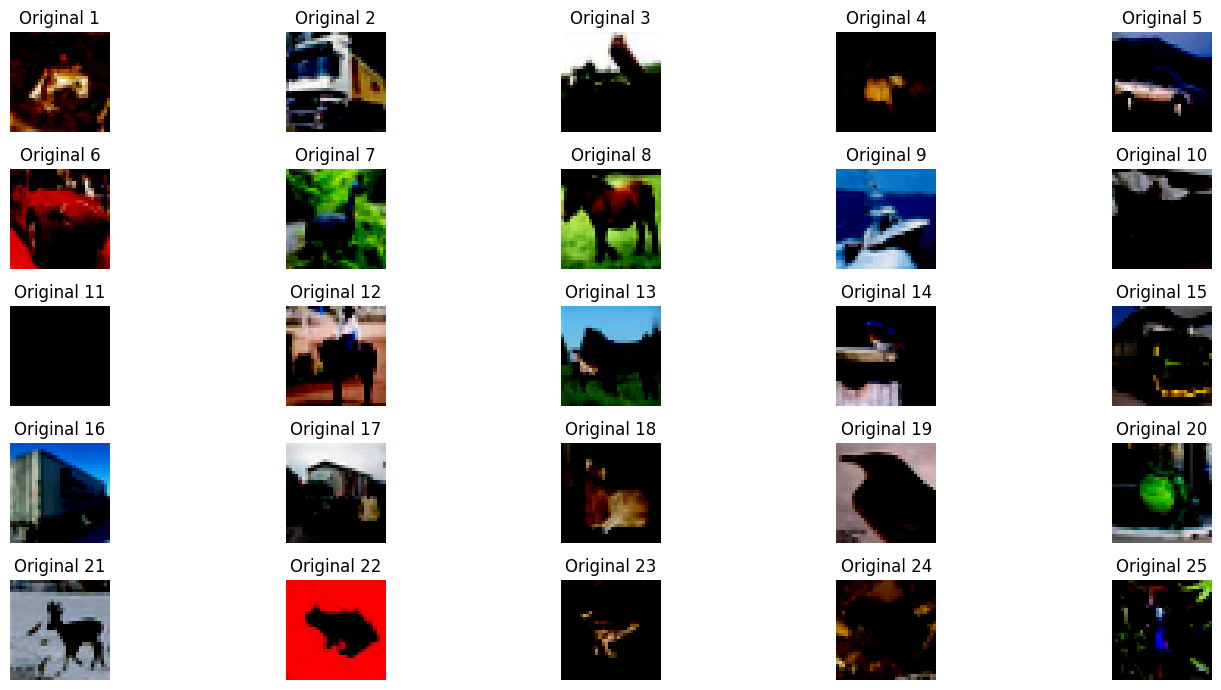

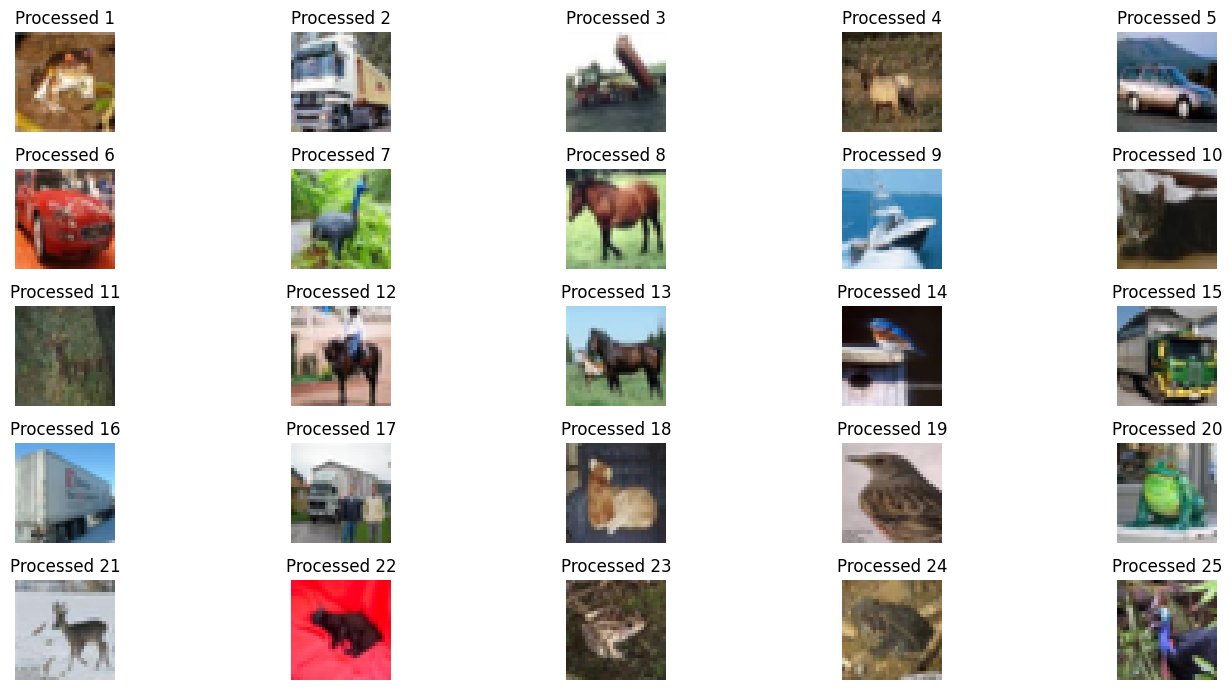

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.4151 - loss: 1.7180 - val_accuracy: 0.6516 - val_loss: 0.9876
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6546 - loss: 0.9855 - val_accuracy: 0.7315 - val_loss: 0.7695
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7192 - loss: 0.8081 - val_accuracy: 0.7364 - val_loss: 0.7514
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7512 - loss: 0.7158 - val_accuracy: 0.7884 - val_loss: 0.6090
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7783 - loss: 0.6403 - val_accuracy: 0.7914 - val_loss: 0.6124
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8018 - loss: 0.5713 - val_accuracy: 0.8122 - val_loss: 0.5363
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8150 - loss: 0.5301 - val_accuracy: 0.8125 - val_loss: 0.5528
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8334 - loss: 0.480

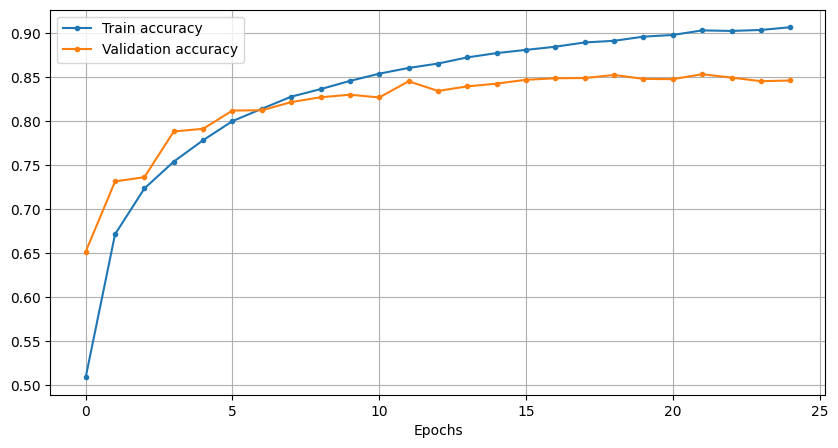

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
import tensorflow as tf

#SEM BLUR PRÉ SHARPENING

# Carregar o dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Exibir as dimensões dos dados
print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")

# Parâmetros da Unsharp Mask
upscale_factor = 2
kernel_size = (3, 3)
sigma = 1
amount = 6

# Pré-processar x_train
processed_train = np.zeros_like(x_train)
for i in range(x_train.shape[0]):
    img_bgr = cv2.cvtColor(x_train[i], cv2.COLOR_RGB2BGR)
    sharpened_bgr = cv2.addWeighted(img_bgr, 1 + amount, img_bgr, -amount, 0)
    processed_train[i] = cv2.cvtColor(sharpened_bgr, cv2.COLOR_BGR2RGB)

# Pré-processar x_test
processed_test = np.zeros_like(x_test)
for i in range(x_test.shape[0]):
    img_bgr = cv2.cvtColor(x_test[i], cv2.COLOR_RGB2BGR)
    sharpened_bgr = cv2.addWeighted(img_bgr, 1 + amount, img_bgr, -amount, 0)
    processed_test[i] = cv2.cvtColor(sharpened_bgr, cv2.COLOR_BGR2RGB)

# Normalizar as imagens para o intervalo [-1, 1]
x_train, x_test = (processed_train / 255.0 - 0.5) * 2, (processed_test / 255.0 - 0.5) * 2

# Plotar as primeiras 25 imagens da base antes e depois do upscaling
fig, axes = plt.subplots(5, 5, figsize=(15, 7))
axes = axes.flatten()

# Plotar as primeiras 25 imagens originais e processadas
for i in range(25):
    # Imagem original
    axes[i].imshow(x_train[i])
    axes[i].set_title(f'Original {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Plotar as imagens processadas (após o upscaling e sharpen)
fig, axes = plt.subplots(5, 5, figsize=(15, 7))
axes = axes.flatten()

for i in range(25):
    # Imagem processada
    axes[i].imshow(processed_train[i])
    axes[i].set_title(f'Processed {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Criar o modelo
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Primeiro bloco convolucional
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Segundo bloco convolucional
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Terceiro bloco convolucional
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Camadas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')  # Saída para 10 classes
])

# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

# Avaliar o modelo
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Plotar histórico de treinamento
plt.figure(figsize=(10, 5))

# Acurácia
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], '.-', label='Train accuracy')
plt.plot(history.history['val_accuracy'], '.-', label='Validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

plt.show()

# Salvar o modelo treinado
model.save('/content/drive/MyDrive/Colab Notebooks/v44.h5')
